In [5]:
import os
n_cores = 5
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
MACHINE_EPSILON = lambda x: np.abs(x) * np.finfo(np.float64).eps

from online_cp.CPS import RidgePredictionMachine

In [6]:
# TODO must be vectorised
def integrate_jump_function(jump_points, values):
    integral = 0
    # Loop over each pair of consecutive jump points
    for i in range(1, len(jump_points)):
        # Get the length of the current interval
        interval_length = jump_points[i] - jump_points[i - 1]
        # Multiply by the function value on that interval
        integral += interval_length * values[i - 1]
    return integral

def CRPS(cpd, label):
    y = label
    choice = lambda x: cpd(x, 0) if x <= y else cpd(x,1)
    func = lambda x: (choice(x) - int(y <= x))**2

    jump_points = np.unique(cpd.y_vals[1:-1])
    crps = integrate_jump_function(
        jump_points,
        np.array([func(y) for y in jump_points])
    )
    return crps

In [7]:
N = 2000
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
Y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

Running online conformal prediction:   0%|          | 0/1980 [00:00<?, ?it/s]

/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:136: UserWarning: Exchangeability assumption likely violated: Max martingale value is 104.21743870857104
  warnings.warn(f'Exchangeability assumption likely violated: Max martingale value is {self.max}')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:136: UserWarning: Exchangeability assumption likely violated: Max martingale value is 144.14712462800867
  warnings.warn(f'Exchangeability assumption likely violated: Max martingale value is {self.max}')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:136: UserWarning: Exchangeability assumption likely violated: Max martingale value is 260.619621427878
  warnings.warn(f'Exchangeability assumption likely violated: Max martingale value is {self.max}')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:136: UserWarning: Exchangeability 

Error rate: 0.1601010101010101
Maximum martingale value: 1.3128611529151955e+19


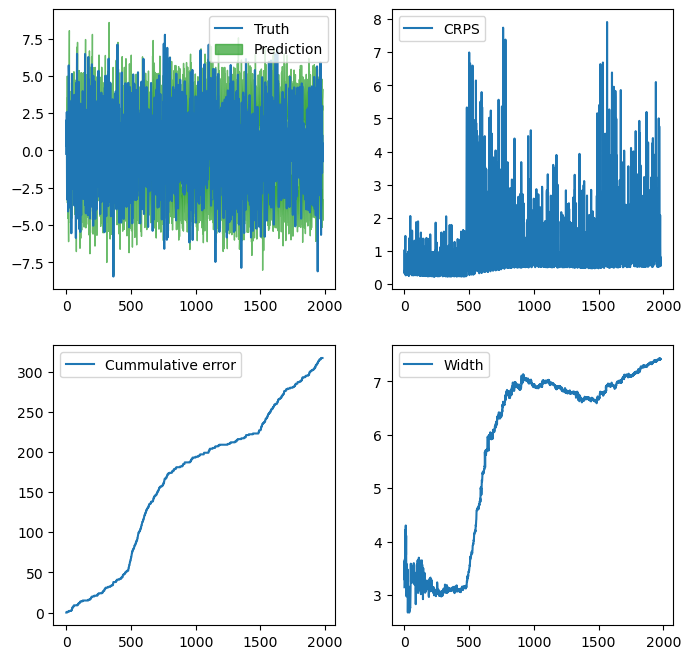

In [8]:
cps = RidgePredictionMachine()

from online_cp.martingale import PluginMartingale

martingale = PluginMartingale(warning_level=100)

epsilon = 0.1

Err = 0 

cps.learn_initial_training_set(X[:int(np.ceil(2/epsilon))], Y[:int(np.ceil(2/epsilon))])

res = np.zeros(shape=(N-20, 9))

for i, (object, label) in tqdm(enumerate(zip(X[int(np.ceil(2/epsilon)):], Y[int(np.ceil(2/epsilon)):])), total=N-20, desc='Running online conformal prediction'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use
    
    # Which can be used to compute a prediction set
    Gamma = cpd.predict_set(tau=tau, epsilon=epsilon)

    # For evaluation

    # And perhaps the median is interesting too
    median = cpd.quantile(0.5, tau=tau)

    # Reality outputs label

    # Observe error
    err = cpd.err(Gamma=Gamma, y=label)
    Err += err

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations
    
    crps = CRPS(cpd, label)

    # Compute p-value
    p = cpd(y=label, tau=tau)

    # Update martingale
    martingale.update_martingale_value(p)

    res[i, 0] = Gamma[0]
    res[i, 1] = Gamma[1]
    res[i, 2] = label
    res[i, 3] = err
    res[i, 4] = Err
    res[i, 5] = cpd.width(Gamma)
    res[i, 6] = martingale.logM
    res[i, 7] = median
    res[i, 8] = crps

    if i > 1:
        pass

print(f'Error rate: {Err/(N-20)}')
print(f'Maximum martingale value: {martingale.max}')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs[0,0].plot(res[:, 2], label='Truth')
axs[0,0].fill_between(
    x=[i for i in range(N-20)],
    y1=res[:, 0],
    y2=res[:, 1],
    color='C2',
    alpha=0.7,
    label='Prediction'
)
axs[0,0].legend()

axs[0,1].plot(res[:,8], label='CRPS')
axs[0,1].legend()

axs[1,0].plot(res[:, 4], label='Cummulative error')
axs[1,0].legend()

axs[1,1].plot(res[:, 5], label='Width')
axs[1,1].legend()

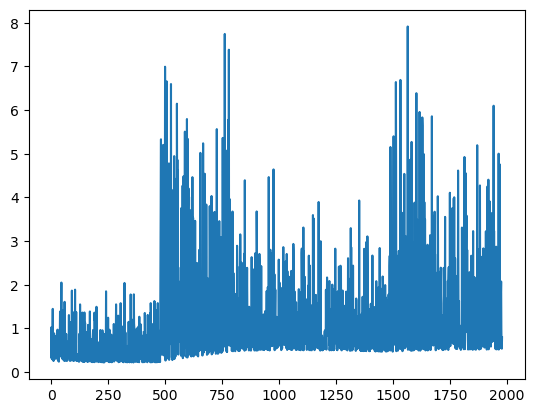

In [9]:
plt.plot(res[:, 8])

The width criterion depends on $\varepsilon$, which is a bit irritating. We could integrate over $\varepsilon$ to get rid of it, but for som evalues, the width will be infinite... Is it possible to easily find the smalles $\varepsilon$ that yields a finite interval? Here is at least a plot of what is to be integrated.

(0.0, 1.0)

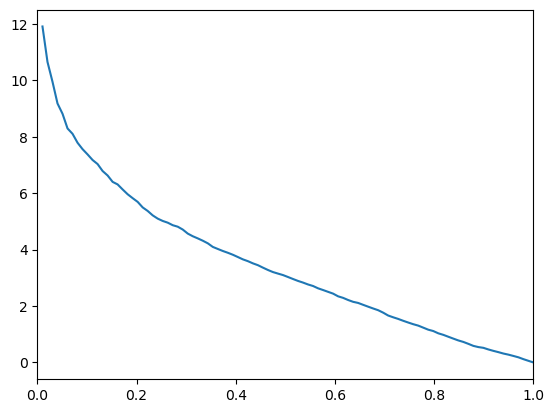

In [10]:
func = lambda epsilon: cpd.width(cpd.predict_set(tau, epsilon, minimise_width=False))

Epsilon = np.linspace(0.0, 1.0, endpoint=True, num=100)

plt.plot(
    Epsilon,
    [func(epsilon) for epsilon in Epsilon]
)
plt.xlim(0, 1)

Now for CRPS...

This seems like cheating. We use $\tau=0$ if $x\leq y$ and $\tau=1$ when $x>y$ to ensure convergence.

In [11]:
CRPS(cpd, label)

0.7949238721220286